In [1]:
!pip install kneed -q

In [3]:
!pip install annoy -q

import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from annoy import AnnoyIndex
from kneed import KneeLocator
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
# setup random seed

RANDOM_SEED = 24
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

1. Data Preprocessing

In [6]:
df = df = pd.read_csv('/content/[Provinsi]  Kemiskinan, 2020.csv')
display(df.head(2))
display(df.describe())
display(df.info())

,Kota - Desa,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,NaN,[Provinsi] Kemiskinan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Garis Kemiskinan,NaN,Indeks Keparahan Keminskinan,NaN,Indeks Kedalaman Kemiskinan,NaN,Persentase Kemiskinan (persen),NaN,Jumlah Penduduk Miskin (ribu),NaN


,Kota - Desa,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
count,3,7,4,6,4,6,4,6,4,6,4
unique,3,7,4,6,4,6,4,6,4,6,4
top,Perkotaan,[Provinsi] Kemiskinan,Semester 2 (September),Indeks Keparahan Keminskinan,Semester 2 (September),Indeks Kedalaman Kemiskinan,Semester 2 (September),Persentase Kemiskinan (persen),Semester 2 (September),Jumlah Penduduk Miskin (ribu),Semester 2 (September)
freq,1,1,1,1,1,1,1,1,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Kota - Desa  3 non-null      object
 1   Unnamed: 1   7 non-null      object
 2   Unnamed: 2   4 non-null      object
 3   Unnamed: 3   6 non-null      object
 4   Unnamed: 4   4 non-null      object
 5   Unnamed: 5   6 non-null      object
 6   Unnamed: 6   4 non-null      object
 7   Unnamed: 7   6 non-null      object
 8   Unnamed: 8   4 non-null      object
 9   Unnamed: 9   6 non-null      object
 10  Unnamed: 10  4 non-null      object
dtypes: object(11)
memory usage: 748.0+ bytes


None

1.1 Mengatasi Data Kosong (Missing Values)

In [7]:
df.isnull().sum()

,0
Kota - Desa,4
Unnamed: 1,0
Unnamed: 2,3
Unnamed: 3,1
Unnamed: 4,3
Unnamed: 5,1
Unnamed: 6,3
Unnamed: 7,1
Unnamed: 8,3
Unnamed: 9,1


1.2 Membuat 1 Fitur Baru

In [11]:
# Buat kolom selisih persentase kemiskinan antara kota dan desa
# The KeyError occurs because 'Persentase_Kemiskinan_Kota' and 'Persentase_Kemiskinan_Desa'
# do not exist as column names in the current DataFrame.
# Based on the df.head() and df.info(), the data seems to be in 'Unnamed: 1' and 'Unnamed: 2'.
# These columns are currently of 'object' type and need to be converted to numeric for subtraction.

# Assign 'Unnamed: 1' to 'Persentase_Kemiskinan_Kota' and convert to numeric, handling potential errors.
df['Persentase_Kemiskinan_Kota'] = pd.to_numeric(df['Unnamed: 1'], errors='coerce')
# Assign 'Unnamed: 2' to 'Persentase_Kemiskinan_Desa' and convert to numeric, handling potential errors.
df['Persentase_Kemiskinan_Desa'] = pd.to_numeric(df['Unnamed: 2'], errors='coerce')

df['gap_kota_desa'] = df['Persentase_Kemiskinan_Kota'] - df['Persentase_Kemiskinan_Desa']

print('=== STATISTIK GAP KOTA-DESA ===')
display(df['gap_kota_desa'].describe())
print('\n')
print('=== 20 DATA PERTAMA GAP KOTA-DESA ===')
display(df['gap_kota_desa'].head(20))

=== STATISTIK GAP KOTA-DESA ===


,gap_kota_desa
count,3.000000
mean,-3545.333333
std,255.220166
min,-3762.000000
25%,-3686.000000
50%,-3610.000000
75%,-3437.000000
max,-3264.000000




=== 20 DATA PERTAMA GAP KOTA-DESA ===


,gap_kota_desa
0,NaN
1,NaN
2,NaN
3,NaN
4,-3610.0
5,-3264.0
6,-3762.0


1.3 Normalisasi / Standardisas

,column,IQR_outliers_count,Zscore_outliers_count,sample_IQR,sample_Z
0,Persentase_Kemiskinan_Kota,1,0,[2020.0],[]
1,Persentase_Kemiskinan_Desa,0,0,[],[]
2,gap_kota_desa,0,0,[],[]


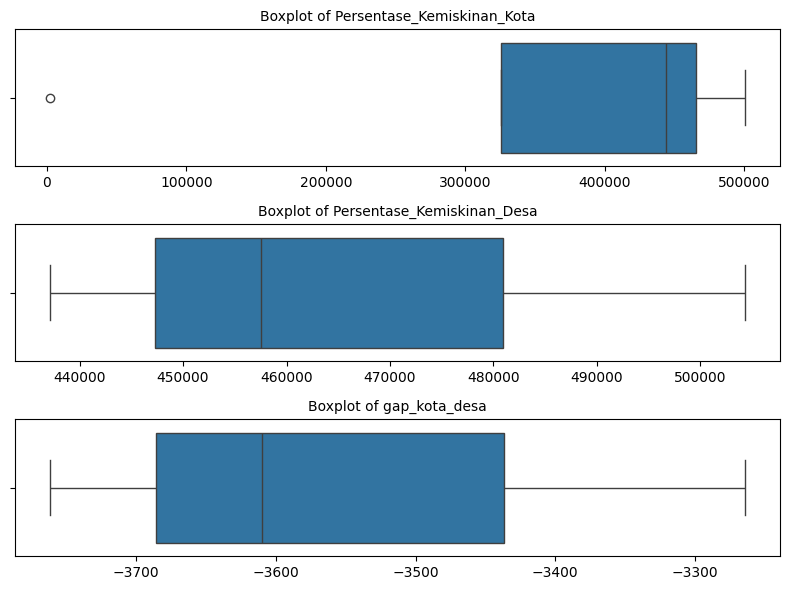

In [13]:
# numeric columns
num_cols = ["Persentase_Kemiskinan_Kota", "Persentase_Kemiskinan_Desa", "gap_kota_desa"]

outlier_summary = []

for col in num_cols:
    # IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)][col]

    # Z-score method
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    outliers_z = df[z_scores > 3][col]

    # Store summary
    outlier_summary.append({
        "column": col,
        "IQR_outliers_count": len(outliers_iqr),
        "Zscore_outliers_count": len(outliers_z),
        "sample_IQR": outliers_iqr.head(3).tolist(),  # first 3 values as example
        "sample_Z": outliers_z.head(3).tolist()
    })

# Convert summary to DataFrame for easy viewing
summary_df = pd.DataFrame(outlier_summary)
display(summary_df)


# Boxplot visualization
fig, axes = plt.subplots(len(num_cols), 1, figsize=(8, len(num_cols)*2))

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}', fontsize=10)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

In [14]:
print('Data sebelum dilakukan proses normalisasi')
display(df[num_cols].head())

print('\nDeskripsi data')
display(df[num_cols].describe())



scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print('\n\nData setelah dilakukan proses normalisasi')
display(df[num_cols].head())

print('\nDeskripsi data')
display(df[num_cols].describe())

Data sebelum dilakukan proses normalisasi


,Persentase_Kemiskinan_Kota,Persentase_Kemiskinan_Desa,gap_kota_desa
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,2020.0,NaN,NaN
3,NaN,NaN,NaN
4,500720.0,504330.0,-3610.0



Deskripsi data


,Persentase_Kemiskinan_Kota,Persentase_Kemiskinan_Desa,gap_kota_desa
count,4.000000,3.000000,3.000000
mean,347579.000000,466310.666667,-3545.333333
std,232072.788706,34467.664794,255.220166
min,2020.000000,437107.000000,-3762.000000
25%,325887.250000,447301.000000,-3686.000000
50%,443788.000000,457495.000000,-3610.000000
75%,465479.750000,480912.500000,-3437.000000
max,500720.000000,504330.000000,-3264.000000




Data setelah dilakukan proses normalisasi


,Persentase_Kemiskinan_Kota,Persentase_Kemiskinan_Desa,gap_kota_desa
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,-1.719362,NaN,NaN
3,NaN,NaN,NaN
4,0.761968,1.350947,-0.310321



Deskripsi data


,Persentase_Kemiskinan_Kota,Persentase_Kemiskinan_Desa,gap_kota_desa
count,4.000000e+00,3.000000e+00,3.000000e+00
mean,2.775558e-17,-6.846375e-16,6.661338e-16
std,1.154701e+00,1.224745e+00,1.224745e+00
min,-1.719362e+00,-1.037698e+00,-1.039735e+00
25%,-1.079294e-01,-6.754734e-01,-6.750281e-01
50%,4.786972e-01,-3.132484e-01,-3.103210e-01
75%,5.866266e-01,5.188492e-01,5.198676e-01
max,7.619678e-01,1.350947e+00,1.350056e+00


2. Klusterisasi

In [17]:
# Buat target classification berdasarkan persentase kemiskinan
# Correcting the KeyError by using 'Persentase_Kemiskinan_Kota' as the base for classification.
df['kategori_kemiskinan'] = pd.cut(df['Persentase_Kemiskinan_Kota'],
                                    bins=[0, 5, 15, 100],
                                    labels=['Rendah', 'Sedang', 'Tinggi'])

X = df.drop('kategori_kemiskinan', axis=1)
y = df['kategori_kemiskinan']

print("=== FEATURES (X) ===")
display(X.head(20))

print("\n=== TARGET (y) - Kategori Kemiskinan ===")
display(y.head(20))

=== FEATURES (X) ===


,Kota - Desa,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Persentase_Kemiskinan_Kota,Persentase_Kemiskinan_Desa,gap_kota_desa
0,NaN,[Provinsi] Kemiskinan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Garis Kemiskinan,NaN,Indeks Keparahan Keminskinan,NaN,Indeks Kedalaman Kemiskinan,NaN,Persentase Kemiskinan (persen),NaN,Jumlah Penduduk Miskin (ribu),NaN,NaN,NaN,NaN
2,NaN,2020,NaN,2020,NaN,2020,NaN,2020,NaN,2020,NaN,-1.719362,NaN,NaN
3,NaN,Semester 1 (Maret),Semester 2 (September),Semester 1 (Maret),Semester 2 (September),Semester 1 (Maret),Semester 2 (September),Semester 1 (Maret),Semester 2 (September),Semester 1 (Maret),Semester 2 (September),NaN,NaN,NaN
4,Perkotaan,500720,504330,0.24,0.29,1.23,1.31,9.02,9.59,237.1,259.28,0.761968,1.350947,-0.310321
5,Pedesaan,433843,437107,0.49,0.7,2.2,2.48,13.83,14.22,812.22,831.86,0.429215,-1.037698,1.350056
6,Pedesaan + Perkotaan,453733,457495,0.41,0.57,1.9,2.11,12.34,12.76,1049.32,1091.14,0.528179,-0.313248,-1.039735



=== TARGET (y) - Kategori Kemiskinan ===


,kategori_kemiskinan
0,NaN
1,NaN
2,NaN
3,NaN
4,Rendah
5,Rendah
6,Rendah


2.1 k-Means

2.1.1 Menemukan nilai k terbaik

2.1.1.1 Elbow method

k=1, inertia=6.0584
k=2, inertia=1.6781
k=3, inertia=0.0000


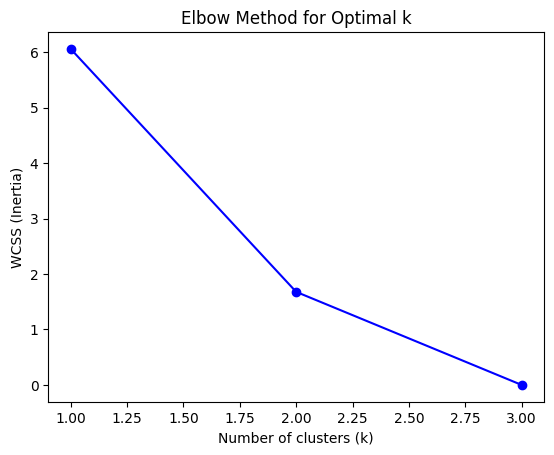


Optimal k (elbow): None


In [20]:
wcss = []
K_range = range(1, X_numeric.shape[0] + 1) # Limit k to the number of samples
inertia_list = []

# Prepare the data for KMeans: select numerical columns and handle NaNs
X_numeric = df[num_cols].dropna()

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    kmeans.fit(X_numeric)
    inertia = kmeans.inertia_ # inertia_ = WCSS
    inertia_list.append(inertia)
    print(f"k={k}, inertia={inertia:.4f}")
    wcss.append(inertia)

# Plot the elbow
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Automatically detect elbow
knee = KneeLocator(K_range, inertia_list, curve="convex", direction="decreasing")
print("\nOptimal k (elbow):", knee.knee)

2.1.1.2 Silhouette score

k=2, silhouette score=0.2138


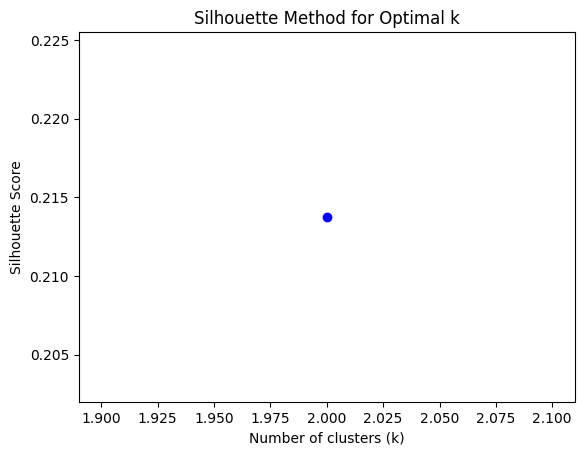

In [23]:
s_scores = []
K_range = range(2, X_numeric.shape[0]) # Limit k to be less than n_samples

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = kmeans.fit_predict(X_numeric)
    score = silhouette_score(X_numeric, labels)
    print(f"k={k}, silhouette score={score:.4f}")
    s_scores.append(score)

# Plot
plt.plot(K_range, s_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

2.1.2 Model training

In [24]:
# k from Elbow
k_elbow = 2
kmeans_elbow = KMeans(n_clusters=k_elbow, random_state=RANDOM_SEED, n_init=10)
kmeans_labels_elbow = kmeans_elbow.fit_predict(X_numeric)
sil_elbow = silhouette_score(X_numeric, kmeans_labels_elbow)

# k from Silhouette
k_sil = 2
kmeans_sil = KMeans(n_clusters=k_sil, random_state=RANDOM_SEED, n_init=10)
kmeans_labels_sil = kmeans_sil.fit_predict(X_numeric)
sil_sil = silhouette_score(X_numeric, kmeans_labels_sil)

print(f"Elbow k={k_elbow}, Silhouette={sil_elbow:.3f}")
print(f"Silhouette k={k_sil}, Silhouette={sil_sil:.3f}")

Elbow k=2, Silhouette=0.214
Silhouette k=2, Silhouette=0.214


2.1.3 Visualisasi

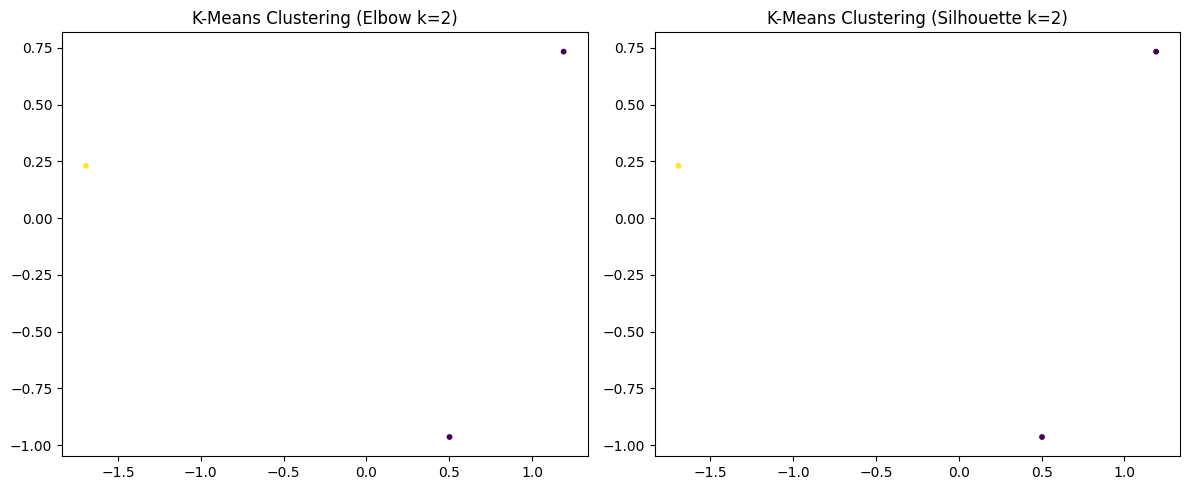

In [26]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_numeric)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Elbow k
axes[0].scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=kmeans_labels_elbow,
    cmap='viridis',
    s=10  # size of points
)
axes[0].set_title(f"K-Means Clustering (Elbow k={k_elbow})")

# Plot Silhouette k
axes[1].scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=kmeans_labels_sil,
    cmap='viridis',
    s=10
)
axes[1].set_title(f"K-Means Clustering (Silhouette k={k_sil})")

plt.tight_layout()
plt.show()

2.1.4 Pengujian

In [28]:
df_compare = pd.DataFrame({
    'Target': y.loc[X_numeric.index],
    'Cluster': kmeans_labels_sil
})

# Cross-tabulation
ct = pd.crosstab(df_compare['Cluster'], df_compare['Target'])
ct

Target,Rendah
Cluster,
0,2
1,1


In [30]:
from sklearn.preprocessing import LabelEncoder

# Ensure y_aligned and kmeans_labels_sil have consistent lengths
# y_aligned should correspond to the indices of X_numeric
y_aligned = y.loc[X_numeric.index]

# Convert y_aligned categorical labels to numerical for accuracy_score
le = LabelEncoder()
y_aligned_encoded = le.fit_transform(y_aligned)

# K-Means cluster labels are arbitrary (0, 1, etc.).
# We check accuracy for the original labels and for flipped labels (1-labels)
# and take the higher accuracy, assuming binary classification.

# Calculate accuracy with current kmeans_labels_sil
acc_original = accuracy_score(y_aligned_encoded, kmeans_labels_sil)

# Calculate accuracy with flipped kmeans_labels_sil (assuming binary labels 0/1)
kmeans_labels_sil_flipped = 1 - kmeans_labels_sil
acc_flipped = accuracy_score(y_aligned_encoded, kmeans_labels_sil_flipped)

# Choose the one with higher accuracy
if acc_original >= acc_flipped:
    accuracy = acc_original
else:
    accuracy = acc_flipped

print(f"Clustering accuracy vs target: {accuracy:.3f}")

Clustering accuracy vs target: 0.667


2.2 DBSCAN

2.2.1 Konfigurasi Awal DBSCAN

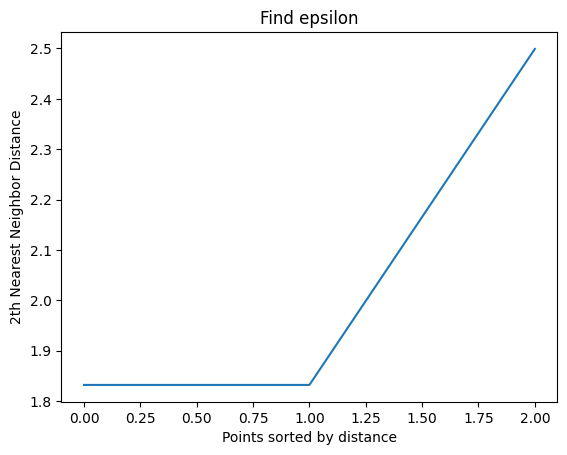


Optimal eps: [[1.83200659 1.83200659 2.49914474]]


In [33]:
min_samples = X_numeric.shape[0] - 1 # Adjusted to be compatible with dataset size

neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_numeric)
distances, indices = nbrs.kneighbors(X_numeric)

distances = np.sort(distances[:, -1])

# Plot
plt.plot(distances)
plt.ylabel(f"{min_samples}th Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.title("Find epsilon")
plt.show()


# Penentuan nilai epsilon paling optimum secara otomatis
knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
eps_opt = distances[knee.knee]
print("\nOptimal eps:", eps_opt)

2.2.2 Model training

In [35]:
dbscan = DBSCAN(eps=np.max(eps_opt), min_samples=X_numeric.shape[0] - 1)
dbscan_labels = dbscan.fit_predict(X_numeric)

dbscan_labels

array([0, 0, 0])

In [39]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_numeric)


2.2.3 Visualisasi

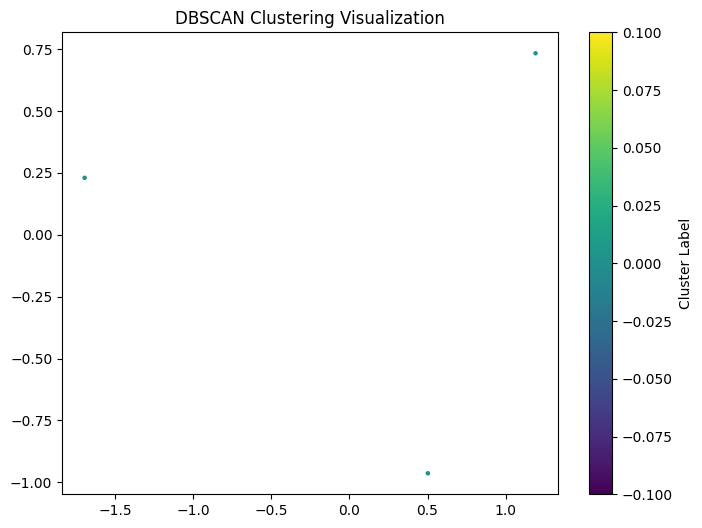

In [41]:
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(X_numeric)

# 2D Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_2d[:, 0], reduced_2d[:, 1],
    c=dbscan_labels,
    cmap='viridis',
    s=5
)
plt.title("DBSCAN Clustering Visualization")
plt.colorbar(label='Cluster Label')
plt.show()

2.3 Perbandingan Hasil

In [43]:
sil_kmeans_1 = silhouette_score(X_numeric, kmeans_labels_elbow)
dbi_kmeans_1 = davies_bouldin_score(X_numeric, kmeans_labels_elbow)

sil_kmeans_2 = silhouette_score(X_numeric, kmeans_labels_sil)
dbi_kmeans_2 = davies_bouldin_score(X_numeric, kmeans_labels_sil)

sil_dbscan = silhouette_score(X_numeric, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
dbi_dbscan = davies_bouldin_score(X_numeric, dbscan_labels) if len(set(dbscan_labels)) > 1 else None

print(f"K-Means 1 (elbow)  → Silhouette: {sil_kmeans_1:.3f}, DBI: {dbi_kmeans_1:.3f}")
print(f"K-Means 2 (silhouette) → Silhouette: {sil_kmeans_2:.3f}, DBI: {dbi_kmeans_2:.3f}")
print(f"DBSCAN   → Silhouette: {sil_dbscan}, DBI: {dbi_dbscan}")

K-Means 1 (elbow)  → Silhouette: 0.214, DBI: 0.357
K-Means 2 (silhouette) → Silhouette: 0.214, DBI: 0.357
DBSCAN   → Silhouette: None, DBI: None


3. Analisis

4. ANN (Approximate Nearest Neighbor)

In [45]:
f = X_numeric.shape[1]
index = AnnoyIndex(f, 'euclidean')

# Add each vector into the index
for i, vector in enumerate(X_numeric.values):
    index.add_item(i, vector)

# Build the forest
index.build(10)

True

In [47]:
query_index = 0  # Changed query_index to a valid index
k = 5

neighbors, distances = index.get_nns_by_item(
    query_index,
    k,
    include_distances=True
)

print("Query index:", query_index)
print("Nearest neighbors:", neighbors)
print("Distances:", distances)

Query index: 0
Nearest neighbors: [0, 2, 1]
Distances: [0.0, 1.832006573677063, 2.9280030727386475]
